In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import os
import cv2
import numpy as np
from collections import defaultdict

#import scikitplot
import seaborn as sns
from matplotlib import pyplot

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import TimeDistributed, LSTM, Bidirectional
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os,cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import keras

from keras.utils import np_utils
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
from keras.models import Sequential
from keras.layers import Dense , Activation , Dropout ,Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.metrics import categorical_accuracy
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
from keras.optimizers import *
from tensorflow.keras.layers import BatchNormalization
import os

In [ ]:
# Any results you write to the current directory are saved as output

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.datasets import make_classification
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [ ]:
#------------------------------------------------------------------------------
# Data overview
#------------------------------------------------------------------------------

In [ ]:
data_path = '/content/drive/Shareddrives/cis600/600Paper/DataSet/CK+48/'

In [ ]:
data_dir_list = os.listdir(data_path)

num_epoch=10

img_data_list=[]


for dataset in data_dir_list:
    img_list=os.listdir(data_path+'/'+ dataset)
    print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
    for img in img_list:
        input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img )
        #input_img=cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
        input_img_resize=cv2.resize(input_img,(48,48))
        img_data_list.append(input_img_resize)
        
img_data = np.array(img_data_list)
img_data = img_data.astype('float32')
img_data = img_data/255
img_data.shape

Loaded the images of dataset-disgust

Loaded the images of dataset-contempt

Loaded the images of dataset-fear

Loaded the images of dataset-sadness

Loaded the images of dataset-happy

Loaded the images of dataset-surprise

Loaded the images of dataset-anger



(981, 48, 48, 3)

In [ ]:
#Putting label in data

In [ ]:
num_classes = 7

num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,),dtype='int64')

labels[0:134]=0 #135
labels[135:188]=1 #54
labels[189:365]=2 #177
labels[366:440]=3 #75
labels[441:647]=4 #207
labels[648:731]=5 #84
labels[732:980]=6 #249

names = ['anger','contempt','disgust','fear','happy','sadness','surprise']

def getLabel(id):
    return ['anger','contempt','disgust','fear','happy','sadness','surprise'][id]

In [ ]:
#Splitting train test

In [ ]:
Y = np_utils.to_categorical(labels, num_classes)

#Shuffle the dataset
x,y = shuffle(img_data,Y, random_state=2)
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)
x_test=X_test

In [ ]:
#Creating Model

In [ ]:
def create_model():
    input_shape=(48,48,3)

    model = Sequential()
    # model1
    model.add(Conv2D(6, (5, 5), input_shape=input_shape, padding='same', activation = 'relu'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    #model2
    model.add(Conv2D(16, (5, 5), padding='same', activation = 'relu'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    #model3
    model.add(Conv2D(64, (3, 3), activation = 'relu'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # faltten
    model.add(Flatten())
    
    #dense1
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.5))
    
    #output layer
    model.add(Dense(7, activation = 'softmax'))

    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='RMSprop')
    
    return model

In [ ]:
# model summary
model_custom = create_model()
model_custom.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 48, 48, 6)         456       
                                                                 
 activation_36 (Activation)  (None, 48, 48, 6)         0         
                                                                 
 batch_normalization_36 (Bat  (None, 48, 48, 6)        24        
 chNormalization)                                                
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 24, 24, 6)        0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 24, 24, 16)        2416      
                                                                 
 activation_37 (Activation)  (None, 24, 24, 16)      

In [ ]:
#Model Visualization
# from keras.utils.vis_utils import plot_model
# plot_model(model_custom, to_file='model.png')

In [ ]:
#Conduct k-Fold Cross-Validation

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=False)
from keras.preprocessing.image import ImageDataGenerator

aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [ ]:
#Training Model

In [ ]:
BS = 8
EPOCHS = 100

In [ ]:
result = []
scores_loss = []
scores_acc = []
k_no = 0
for train_index, test_index in kf.split(x):
    X_Train_ = x[train_index]
    Y_Train = y[train_index]
    X_Test_ = x[test_index]
    Y_Test = y[test_index]

    #file_path = "/kaggle/working/weights_best_"+str(k_no)+".hdf5"
    #checkpoint = ModelCheckpoint(file_path = path_model, monitor='loss', verbose=0, save_best_only=True, mode='min')
    early = EarlyStopping(monitor="loss", mode="min", patience=8)

    #callbacks_list = [checkpoint, early]
    es = EarlyStopping(monitor='val_loss', patience = 10, mode = 'min', restore_best_weights=True)
    model = create_model()
    hist = model.fit_generator(aug.flow(X_Train_, Y_Train), epochs=EPOCHS,validation_data=(X_Test_, Y_Test), callbacks = [es], verbose=0)
    # model.fit(X_Train, Y_Train, batch_size=batch_size, epochs=epochs, validation_data=(X_Test, Y_Test), verbose=1)
    #model.load_weights(file_path)
    result.append(model.predict(X_Test_))
    score = model.evaluate(X_Test_,Y_Test, verbose=0)
    scores_loss.append(score[0])
    scores_acc.append(score[1])
    k_no+=1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


In [ ]:
print(scores_acc,scores_loss)

[0.10659898817539215, 0.2806122303009033, 0.2142857164144516, 0.13775509595870972, 0.7551020383834839] [1.946825385093689, 1.865418553352356, 1.8636987209320068, 1.9749014377593994, 0.7026929259300232]


In [ ]:
#Evaluating model

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

test_image = X_test[0:1]
print (test_image.shape)

print(model.predict(test_image))
y_pred = model.predict(test_image)
y_pred = np.round(y_pred).astype(int)
print(y_pred)
#print(model.predict_classes(test_image))
print(y_test[0:1])

#predict
y_pred = model.predict(X_test)

Test Loss: 0.553869366645813
Test accuracy: 0.7918781638145447
(1, 48, 48, 3)
[[8.0211979e-01 1.6787589e-01 1.4737623e-03 1.2525928e-03 3.2175964e-04
  6.2508769e-07 2.6955614e-02]]
[[1 0 0 0 0 0 0]]
[[1. 0. 0. 0. 0. 0. 0.]]


In [ ]:
#Visualizing Train,Test--->Accuracy,Loss

<Figure size 432x288 with 0 Axes>

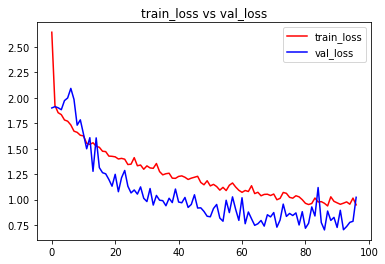

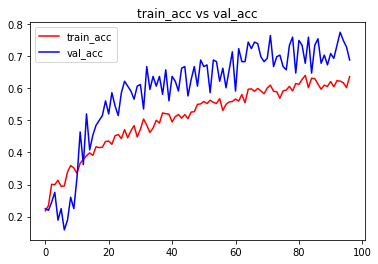

<Figure size 432x288 with 0 Axes>

In [ ]:
# visualizing losses and accuracy
%matplotlib inline

train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['accuracy']
val_acc=hist.history['val_accuracy']

epochs = range(len(train_acc))

plt.plot(epochs,train_loss,'r', label='train_loss')
plt.plot(epochs,val_loss,'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.legend()
plt.figure()

plt.plot(epochs,train_acc,'r', label='train_acc')
plt.plot(epochs,val_acc,'b', label='val_acc')
plt.title('train_acc vs val_acc')
plt.legend()
plt.figure()

In [ ]:
#Model Save
model.save_weights('model_weights.h5')
model.save('model_keras.h5')

In [1]:
from sklearn.metrics import accuracy_score
test_true = np.argmax(y_test, axis=1)
test_pred = np.argmax(model.predict(X_test), axis=1)
print("CNN with CK+45 Model Accuracy on test set: {:.4f}".format(accuracy_score(test_true, test_pred)))

NameError: ignored

In [ ]:
#Confusion Matrix

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots(figsize=(12,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

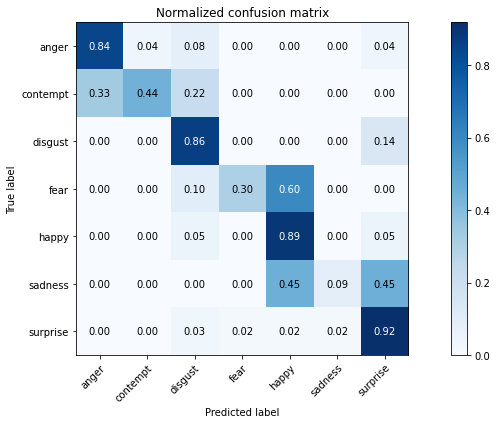

In [ ]:
# Plot normalized confusion matrix
from sklearn.metrics import confusion_matrix
plot_confusion_matrix(test_true, test_pred, classes=names, normalize=True, title='Normalized confusion matrix')
plt.show()

In [ ]:
#ROC Curve

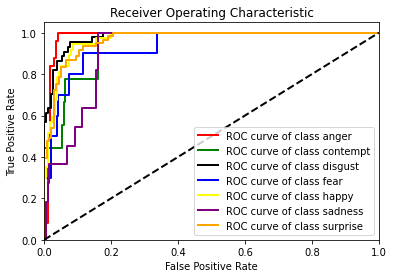

In [ ]:
from sklearn.metrics import roc_curve,auc
from itertools import cycle
new_label = ['anger','contempt','disgust','fear','happy','sadness','surprise']
final_label = new_label
new_class = 7
#ravel flatten the array into single vector
y_pred_ravel = y_pred.ravel()
lw = 2
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(new_class):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
#colors = cycle(['red', 'green','black'])
colors = cycle(['red', 'green','black','blue', 'yellow','purple','orange'])
for i, color in zip(range(new_class), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0}'''.format(final_label[i]))
    

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

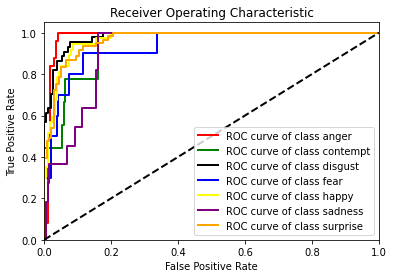

In [ ]:
from sklearn.metrics import roc_curve,auc
from itertools import cycle
new_label = ['anger','contempt','disgust','fear','happy','sadness','surprise']
final_label = new_label
new_class = 7
#ravel flatten the array into single vector
y_pred_ravel = y_pred.ravel()
lw = 2
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(new_class):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
#colors = cycle(['red', 'green','black'])
colors = cycle(['red', 'green','black','blue', 'yellow','purple','orange'])
for i, color in zip(range(new_class), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0}'''.format(final_label[i]))
    

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_det_curve is deprecated; Function plot_det_curve is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: DetCurveDisplay.from_predictions or DetCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


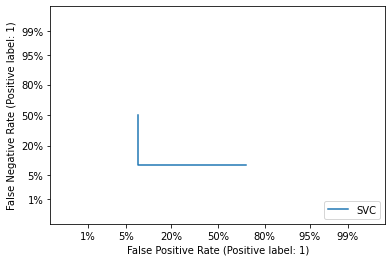

In [ ]:
## DET Curve
from sklearn.metrics import roc_curve,auc
from itertools import cycle

import matplotlib.pyplot as plt  
from sklearn import datasets, metrics, model_selection, svm
X, y = datasets.make_classification(random_state=0)
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, random_state=0)
clf = svm.SVC(random_state=0)
clf.fit(X_train, y_train)

metrics.plot_det_curve(clf, X_test, y_test)  
plt.show()     